In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import scipy as sp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

import pickle
from console_progressbar import ProgressBar

import warnings
warnings.filterwarnings('ignore')

In [2]:
def ShouldRunModels():
    try:
        value = gl.variables.get('run_models')
        if(value == 0):
            return False
        else:
            return True
    except:
        return False

run_mdls = ShouldRunModels()
# manually set if needed
run_mdls = True

print(run_mdls)

True


## Data import

Einlesen des Datensatzes

In [3]:
df_clean = pd.read_csv("./data/df_clean.csv")
df_clean = df_clean.drop(columns=['Unnamed: 0'])
df_clean

,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long
0,2022-04-03 11:47:11.212,Raphi,Sitting,-0.091133,0.351148,0.945756,-23.01530,-26.72410,-33.40970,0.047035,-0.022907,0.008399,0.136017,-0.125171,-0.839552,0.510817,47.500155,8.324881
1,2022-04-03 11:47:11.268,Raphi,Sitting,-0.097963,0.366881,0.898528,-22.97260,-26.59600,-33.26940,-0.050089,-0.041232,-0.025808,0.135422,-0.126965,-0.839437,0.510728,47.500155,8.324881
2,2022-04-03 11:47:11.326,Raphi,Sitting,-0.114793,0.334654,0.998473,-22.77740,-26.51060,-33.09250,0.150879,-0.098041,0.096972,0.134209,-0.126197,-0.839677,0.510821,47.500155,8.324881
3,2022-04-03 11:47:11.388,Raphi,Sitting,-0.075767,0.364564,0.886332,-22.94210,-26.77900,-32.94610,0.196082,0.096208,-0.009926,0.134518,-0.133009,-0.839076,0.510125,47.500155,8.324881
4,2022-04-03 11:47:11.445,Raphi,Sitting,-0.125556,0.378345,0.905358,-23.32640,-27.35240,-32.97050,0.027488,0.019242,0.138510,0.139961,-0.133803,-0.836808,0.512193,47.500155,8.324881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825264,2022-09-03 21:05:20.325,pascal,Walking,0.027898,0.317732,0.957129,34.87500,-15.03750,-24.41250,-0.654447,-0.162791,-0.574426,0.129507,0.170889,0.740303,0.637103,47.446347,8.362131
1825265,2022-09-03 21:05:20.380,pascal,Walking,-0.239099,0.224007,0.882216,34.01250,-16.88438,-24.13125,-0.392622,0.795323,-0.385063,0.118194,0.176197,0.735371,0.643593,47.446347,8.362131
1825266,2022-09-03 21:05:20.434,pascal,Walking,-0.277913,0.324562,0.661350,35.77500,-15.20625,-22.85625,0.217920,0.916576,-0.088115,0.095281,0.186127,0.728054,0.653413,47.446347,8.362131
1825267,2022-09-03 21:05:20.489,pascal,Walking,-0.300963,0.430970,0.786784,36.61875,-15.20625,-22.10625,-0.055740,-0.299621,-0.178291,0.061030,0.207580,0.727188,0.651925,47.446347,8.362131


Zeit zu Datetime konvertieren

In [4]:
df_clean['time'] = pd.to_datetime(df_clean['time'])

## Data preparation

Entferne Gruppen mit weniger als 200 Observationen, also Aktivitäten, welche weniger als 10 Sekunden dauern. Bei diesen handelt es sich oft um Falschaufzeichnungen indem die falsche Aktivität gewählt wurde und dann gleich wieder abgeschalten wurde. Auch sonst macht es nicht wirklich Sinn, Aktivitäten welche weniger als 10 Sekunden dauern in das Modell einfliessen zu lassen, da alleine das Aktivieren, Versorgen des Smartphones, Hervornehmen des Smartphones und Beenden die Hälfte der Zeit andauert.

In [5]:
frames = []
names = df_clean['name'].unique()
for name in names:
    df_per_name = df_clean.copy()
    df_per_name = df_per_name[df_per_name['name'] == name]
    df_per_name['time_difference'] = pd.Series(df_clean.loc[df_clean.index, "time"].values - df_clean.loc[df_clean.index.insert(0, 0)[:-1], "time"].values).dt.total_seconds()
    df_per_name = df_per_name[df_per_name['time_difference'] > 0]
    df_per_name.loc[df_per_name['time_difference'] < 1, 'time_difference'] = None
    df_per_name['time_difference'] = df_per_name['time_difference'].ffill()
    df_per_name = df_per_name.groupby(['time_difference']).filter(lambda x: len(x) > 200)
    frames.append(df_per_name)
df_clean = pd.concat(frames)
df_clean = df_clean.drop(['time_difference'], axis=1)
df_clean = df_clean.reset_index()
df_clean = df_clean.drop(['index'], axis=1)

Wie viele Daten haben die jeweiligen Mitglieder gesammelt?

In [6]:
df_clean['name'].value_counts()

pascal    470451
Flavio    437238
Raphi     354326
Simon     261573
Ronny     239765
Name: name, dtype: int64

Was für Daten sind pro Observation vorhanden?

In [7]:
df_clean.columns

Index(['time', 'name', 'activity', 'acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y',
       'mag_z', 'gyr_x', 'gyr_y', 'gyr_z', 'ori_x', 'ori_y', 'ori_z', 'ori_w',
       'lat', 'long'],
      dtype='object')

#### Verteilungen der verschiedenen Features

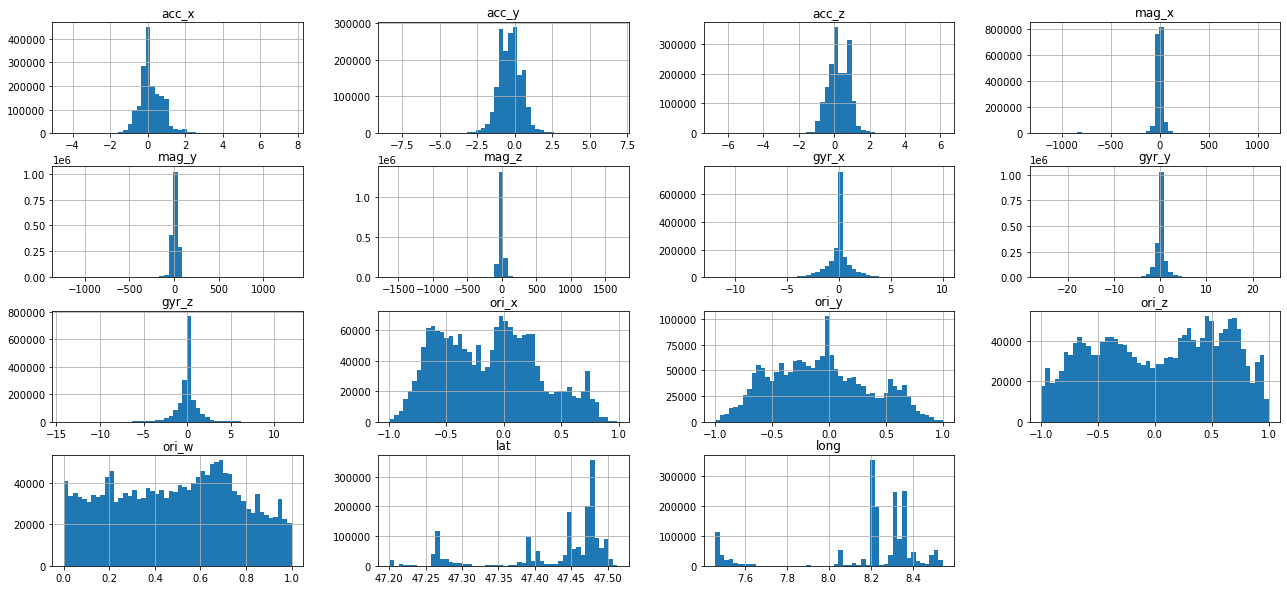

In [8]:
df_clean.iloc[:, 3:18].hist(figsize=(22, 10), bins=50)
plt.show()

Hier wird ersichtlich, dass keine der Variablen normalverteilt ist. Trotzdem wird in Folge versucht, Ausreisser mittels Boxplots zu itentifizieren.

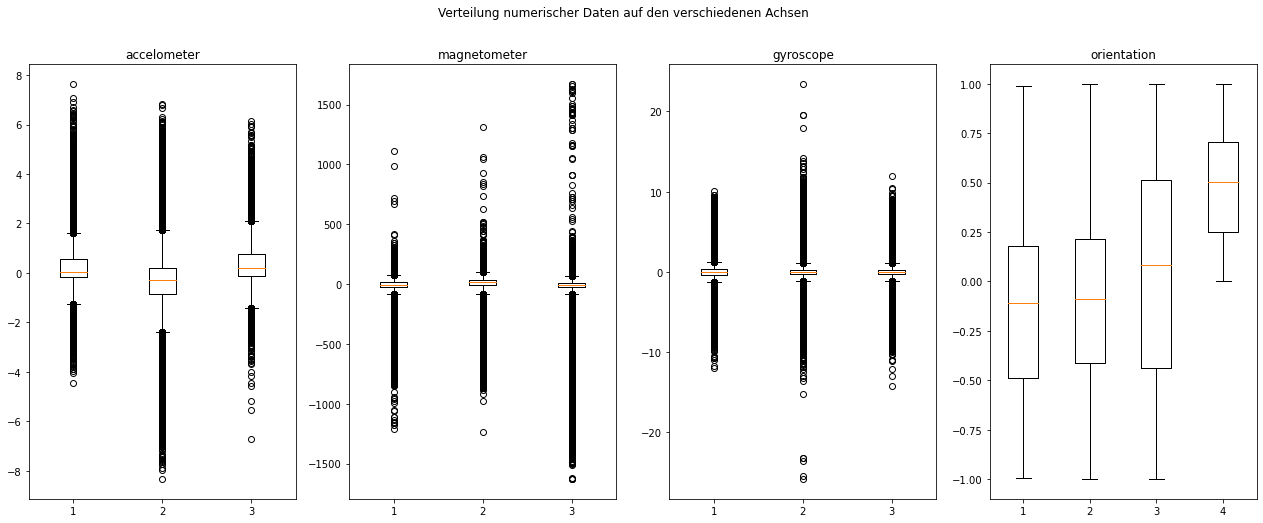

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(22, 8))
axs = axs.flatten()
for i in range(3):
    axs[i].set_title(["accelometer", "magnetometer", "gyroscope"][i])
    axs[i].boxplot(df_clean.iloc[:, i*3 + 3 : i*3 + 6])
    #axs[i] = sns.swarmplot(data=df_clean.iloc[:, i*3 + 3 : i*3 + 6], color="grey")

axs[3].set_title("orientation")
axs[3].boxplot(df_clean.iloc[:, 12:16])

fig.suptitle("Verteilung numerischer Daten auf den verschiedenen Achsen")

plt.show()

Leider konnten anhand der Boxplots keine Ausreisser erkannt werden, welche wir manuell und mit gutem Gewissen entfernen können.

## Aggregation

Um die Achsen der Daten im Modell nicht einzubeziehen (da das Smartphone ja nicht bei allen Personen gleich ausgerichtet ist und so das Modell allgemeiner wird) sollen diese miteinander verrechnet werden. Dafür machen wir die Werte positiv und addieren sie auf. Da alle Achsen gleich skaliert werden sollen, wird anstelle einer Normailsierung mit einem konstanten Wert addiert.

In [10]:
# accelometer
df_clean['acc'] = (df_clean.iloc[:, 3:6] + 10).sum(axis=1)
# magnetometer
df_clean['mag'] = (df_clean.iloc[:, 6:9] + 2000).sum(axis=1)
# gyroscope
df_clean['gyr'] = (df_clean.iloc[:, 9:12] + 30).sum(axis=1)
# orientation
df_clean['ori'] = (df_clean.iloc[:, 12:16] + 1).sum(axis=1)

# drop old axis columns
df_clean.drop(columns=df_clean.columns[3:16], inplace=True)
df_clean.columns

Index(['time', 'name', 'activity', 'lat', 'long', 'acc', 'mag', 'gyr', 'ori'], dtype='object')

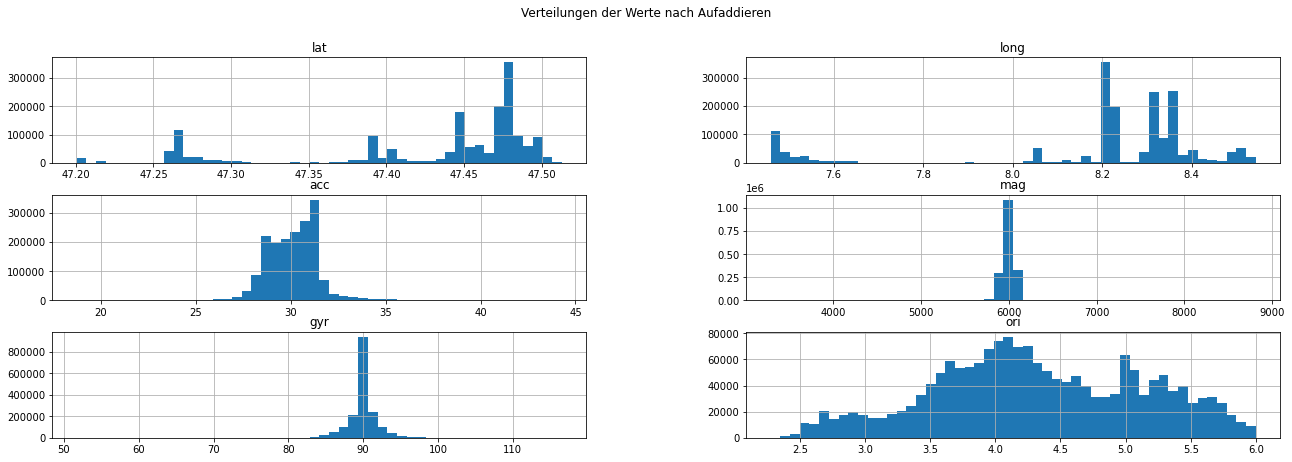

In [11]:
df_clean.iloc[:, 3:].hist(figsize=(22, 7), bins=50)
plt.suptitle('Verteilungen der Werte nach Aufaddieren')
plt.show()

### GPS-Sensor und Geschwindigkeit

Sinnvoller als Koordinatendaten wäre Geschwindigkeit, da ansonsten auf den Ort zurückgeschlossen werden könnte. Dafür werden hier die Koordinaten-Unterschiede berechnet.

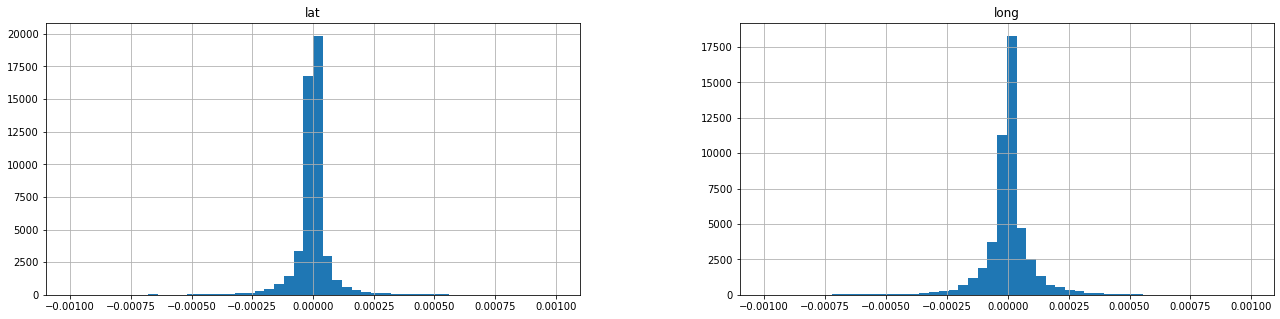

In [12]:
gps_diff = (df_clean.loc[:, ["lat", "long"]] - df_clean.loc[:, ["lat", "long"]].shift(-1))
gps_diff.replace(0, np.NAN, inplace=True)
gps_diff[(abs(gps_diff) < 1e-3)].hist(bins=50, figsize=(22, 5))

plt.show()

Werte ausserhalb diese Bereichs werden als Ausreisser betrachtet und deshalb hier entfernt.

In [13]:
gps_diff[abs(gps_diff) > 1e-3] = np.NAN
gps_diff.describe()

,lat,long
count,4.959600e+04,4.944800e+04
mean,-2.465270e-06,1.867773e-06
std,9.231097e-05,1.155062e-04
min,-9.994700e-04,-9.999500e-04
25%,-1.796099e-05,-2.643000e-05
50%,-3.000000e-08,1.000000e-07
75%,1.572680e-05,2.952000e-05
max,9.987600e-04,9.920400e-04


In [14]:
df_clean["gps_differs"] = (df_clean[["lat", "long"]] - df_clean[["lat", "long"]].shift(-1)).sum(axis=1).astype(bool)
df_clean["gps_differs"].value_counts()

False    1711668
True       51685
Name: gps_differs, dtype: int64

Hier sollen die Koordinatenunterschiede zu Meter umgerechnet werden.

In [15]:
# calculate distance in meters (https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python)
pb = ProgressBar(total=100, decimals=3, length=50)

i = 0
def get_distance(point1, point2):
    if(point1[0] == point2[0] and point1[1] == point2[1]):
        return 0.0

    R = 6370
    lat1 = radians(point1[0])  
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

dists = []
gps_differs_index = df_clean.loc[df_clean["gps_differs"] == True, "gps_differs"].index
for i in range(gps_differs_index.shape[0]):
    dists.append(get_distance(df_clean.loc[gps_differs_index[i], ["lat", "long"]], df_clean.loc[gps_differs_index[i]+1, ["lat", "long"]]))

    if(i % 100 == 0):
        pb.print_progress_bar(i / gps_differs_index.shape[0] * 100)

pb.print_progress_bar(100)
len(dists)

 |██████████████████████████████████████████████████| 100.000% 


51685

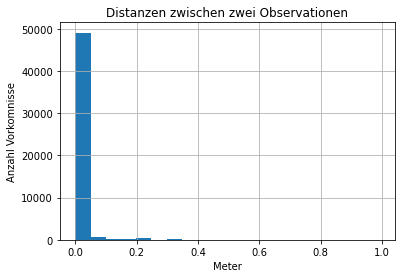

In [16]:
# Verteilung der dists
dists = pd.Series(dists)
dists[(dists < 1)].hist(bins=20)
plt.title("Distanzen zwischen zwei Observationen")
plt.xlabel("Meter")
plt.ylabel("Anzahl Vorkomnisse")
plt.show()

Man sieht, dass die Distanzen immer nur sehr klein sind, abgesehen von einigen Ausreissern. Um jetzt ein besseres Gefühl für diese Distanzen zu bekommen und die verschiedenen Zeitabstände zwischen den Punkten auszugleichen berechnen wir anhand des Zeitunterschieds die Geschwindigkeit.

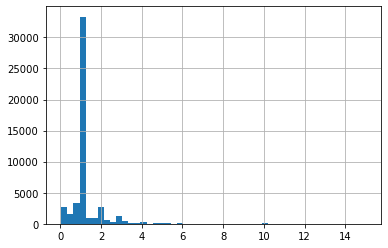

In [17]:
# calculate time differences
time_differences = pd.Series(df_clean.loc[gps_differs_index, "time"].values - df_clean.loc[gps_differs_index.insert(0, 0)[:-1], "time"].values)
time_diff_secs = time_differences.dt.total_seconds()

time_diff_secs[(time_diff_secs < 15) & (time_diff_secs > -10)].hist(bins=50)

plt.show()

Das Zeitintervall der GPS Messungen ist etwa 1s. Um falsche Werte zu verwerfen werden diese auf 0 gesetzt, später durch 0 dividiert.

In [18]:
print(time_diff_secs[(time_diff_secs > 15) | (time_diff_secs < -10)].shape)
time_diff_secs.loc[(time_diff_secs > 10) | (time_diff_secs < 0)] = 0.0

(2279,)


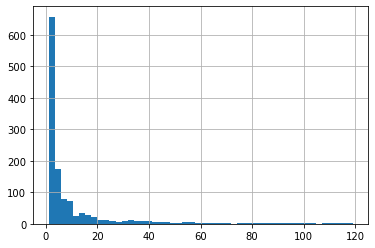

In [19]:
# m/s ausrechen, in km/h umrechnen
kmh = (dists / time_diff_secs * 3.6)
kmh[kmh == np.inf] = np.nan
kmh[kmh > 120] = np.nan
kmh[kmh < 1] = 0
kmh[kmh > 0].hist(bins=50)
plt.show()

In [20]:
# geschwindigkeit inseriteren
df_clean.loc[gps_differs_index, "kmh"] = kmh

Nun müssen wir aufgrund des Delays der GPS-Messung die Daten Forward-Fillen auf die Observationen, welche keine Angaben haben.

In [21]:
# forward fill
df_clean["kmh"] = df_clean["kmh"].ffill().fillna(0)

In [22]:
df_clean.kmh.value_counts()

0.000000     1762355
2.798699         383
1.068762         151
43.381265         59
39.553145         44
13.314394         23
2.287322          23
21.725519         23
1.016302          22
7.408106          22
8.579799          22
3.924800          22
1.705948          22
8.337217          22
40.160921         22
1.340584          22
13.154211         22
3.413145          22
1.946019          21
7.227847          21
3.564326          21
14.012313          5
11.119697          2
8.659531           1
1.701358           1
Name: kmh, dtype: int64

Die GPS Daten haben grösstenteils nicht funktioniert. Die allermeisten Datenpunkte sind 0. Daher sind sie leider nicht zu gebrauchen.

In [23]:
print(df_clean[df_clean["kmh"] > 0].name.unique())
print(df_clean[df_clean["kmh"] > 0].activity.unique())

['Raphi']
['Bicycling']


Die einzige Aktivität, bei welcher grössere Entfernungen gemessen werden konnten, ist Fahrradfahren, jedoch auch nur bei Raphael.

# Filter nach 5sec Abschnitte

Da wir später im Modell nicht jede Observation vorhersagen wollen, sondern grössere Zeitabschnitte, haben wir die Daten in 5-Sekunden-Abschnitte unterteilt. Ausserdem haben wir einen Shifting-Index gemacht, welcher dann bei den Deep Learning Modellen zum Einsatz kommt.

In [24]:
old_time = pd.to_datetime("01.01.2022 00:00:00")

df_clean[f"5s_index_"] = ((df_clean["time"] - old_time).dt.total_seconds() // 5)
df_clean[f"5s_index0"] = ((df_clean["time"] - old_time).dt.total_seconds() // 5)
for i  in range(1, 5):
    df_clean[f"5s_index{i}"] = df_clean[f"5s_index0"].shift(round(i * 90/5))

# inplace shifted values at the beginning
df_clean.fillna(0, inplace=True)

18487


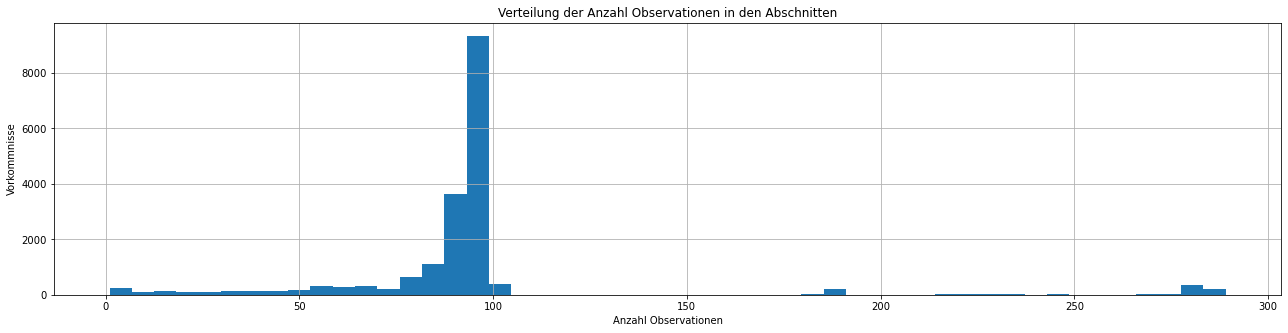

In [25]:
groups = ["5s_index0", "name", "activity"]
df_wind = df_clean.groupby(groups)
# print group count
print(df_wind.size().count())
# count elements per group
df_wind.size().hist(figsize=(22, 5), bins=50)
plt.title("Verteilung der Anzahl Observationen in den Abschnitten")
plt.xlabel("Anzahl Observationen")
plt.ylabel("Vorkommnisse")
plt.show()

Man sieht, dass der Peak bei etwas weniger als 100 Observationen pro 5 Sekunden ist. Dies macht Sinn, da wir festgelegt haben, dass die Sensoren ca. alle 50ms messen sollen. Natürlich gibt es auch immer noch ungültige Messungen, daher ein bisschen weniger als 100. 

Die Abschnitte mit wenigen Observationen sind wahrscheinlich durch schlechtes Internet oder anderen Fehlern entstanden. Wir haben uns dazu entschieden, Observationen mit weniger als 75 Messungen zu entfernen. Bei den Abschnitten mit mehr als 100 Observationen liegt es daran, dass Flavio mit zwei Smartphones gleichzeitig gemessen hat. Dies würde unsere Daten natürlich verfälschen, daher werden wir diese auch entfernen.

### Anspeichern des CSV's für deep learning Modelle

Das Dataframe mit den gruppierten Zeitstempeln nach 5 Sekunden wird als CSV abgespeichert. Dieses dient als Datengrundlage für das Training der deep learning CNN's. Da das CSV schon relativ früh in der Challenge generiert wurde und die Trainingsdaten später noch vereinzelt gefiltert wurden, kann es Unterschied beim erneuten Generieren des CSV geben. Struktur und Inhalt sollten jedoch grösstenteils identisch sein.

In [26]:
df_deep_models = df_clean[["time","name","activity","acc","mag","gyr","ori","kmh","5s_index_"]]
df_deep_models = df_deep_models.rename(columns={"5s_index_":"5s_index"})
df_deep_models

# Abspeichern des aktuellen Dataframes als Datengrundlage für die Modellierung des CNN's
deep_models = "./data/deep_models.csv"
if not os.path.exists(deep_models):
    df_deep_models.to_csv(deep_models)

### Analyse wer doppelt & gleichzeitig gemessen hat (200, 300) Messwerte anstatt 100

15030


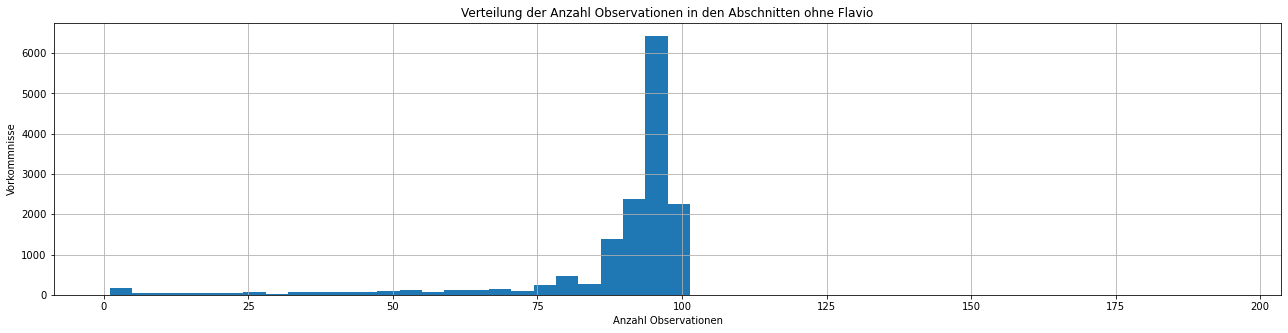

In [27]:
df_wind2 = df_clean.loc[(df_clean["name"] != "Flavio"), :].groupby(groups)
# print group count
print(df_wind2.size().count())
# count elements per group
df_wind2.size().hist(figsize=(22, 5), bins=50)
plt.title("Verteilung der Anzahl Observationen in den Abschnitten ohne Flavio")
plt.xlabel("Anzahl Observationen")
plt.ylabel("Vorkommnisse")
plt.show()
del df_wind2

Hier sehen wir, dass es ohne Flavio nicht mehr als 100 Observationen pro Abschnitt hat.

Als nächstes Entfernen wir also alle Abschnitte mit weniger als 75 und mehr als 110 Observationen.

In [28]:
print(df_wind.size().count())
df_wind = df_wind.filter(lambda g: (g.shape[0] > 75) and (g.shape[0] < 110)).groupby(groups)
print(df_wind.size().count())

18487
15140


Jetzt entfernen wir die Elemente, welche wir den Modellen nicht als Input geben wollen.

In [29]:
target = df_wind[["name", "activity", "5s_index0"]].first().reset_index(drop=True)

Um die Abschnitte besser vergleichen zu können, fassen wir die Variabeln der verschiedenen im Abschnitt inbegriffen Observationen zusammen, indem wir die Varianz, den Durchschnitt, den Median, das Minimum und das Maximum davon erstellten.

In [30]:
cols_for_kmh = df_clean.columns[3:10]
df_clean.drop(columns=["lat", "long", "gps_differs"], inplace=True)
df_agg = df_wind[df_clean.columns[3:8]].agg(["var", "mean", "median", "min", "max"]).reset_index()
np.array(df_agg.columns)

array([('5s_index0', ''), ('name', ''), ('activity', ''), ('acc', 'var'),
       ('acc', 'mean'), ('acc', 'median'), ('acc', 'min'), ('acc', 'max'),
       ('mag', 'var'), ('mag', 'mean'), ('mag', 'median'), ('mag', 'min'),
       ('mag', 'max'), ('gyr', 'var'), ('gyr', 'mean'), ('gyr', 'median'),
       ('gyr', 'min'), ('gyr', 'max'), ('ori', 'var'), ('ori', 'mean'),
       ('ori', 'median'), ('ori', 'min'), ('ori', 'max'), ('kmh', 'var'),
       ('kmh', 'mean'), ('kmh', 'median'), ('kmh', 'min'), ('kmh', 'max')],
      dtype=object)

Um den Multi-Index-Dataframe in den Modellen zu brauchen glätten wir ihn noch.

In [31]:
# flatten mutli index columns
df_agg.columns = ['_'.join(column) for column in df_agg.columns]
df_agg.columns

Index(['5s_index0_', 'name_', 'activity_', 'acc_var', 'acc_mean', 'acc_median',
       'acc_min', 'acc_max', 'mag_var', 'mag_mean', 'mag_median', 'mag_min',
       'mag_max', 'gyr_var', 'gyr_mean', 'gyr_median', 'gyr_min', 'gyr_max',
       'ori_var', 'ori_mean', 'ori_median', 'ori_min', 'ori_max', 'kmh_var',
       'kmh_mean', 'kmh_median', 'kmh_min', 'kmh_max'],
      dtype='object')

Da wir die Zeit nicht als Input für die Modelle wollen, entfernen wir diese noch.

In [32]:
df_agg = df_agg.drop(columns=["5s_index0_"])

### Erstellen der Train-Test-Splits

Nun erstellen wir für die Modelle einen Train-Test-Split mit 80% Trainingsdaten. Wir benutzen ausserdem ein Stratify, damit beim Trainings- und Test-Split die Aktivitäten gleichmässig vorkommen, da es sonst zu einer Verzerrung führen könnte.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_agg.iloc[:, 2:], target["activity"], test_size=0.2, random_state=42, stratify=target["activity"])

In [34]:
y_test.value_counts()

Walking        645
Transport      563
Sitting        472
Bicycling      454
Jogging        423
Stairway       349
Elevatoring    122
Name: activity, dtype: int64

### Test der Geschwindigkeit auf 5-Sekunden-Abschnitten

Da das Berechnen der Geschwindigkeit auf den einzelnen Observationen vielleicht aufgrund der zu kleinen Differenzen, Messfehlern und Delays beim Messen der GPS-Daten nicht funktioniert hat, probieren wir die Geschwindigkeit nochmals anhand der Entfernung der GPS-Daten-Mediane zwische zwei folgenden 5-Sekunden-Abschnitten zu berechnen.

In [35]:
df_agg_kmh_test = df_wind[cols_for_kmh].agg(["median"]).reset_index()
df_agg_kmh_test.columns = ['_'.join(column) for column in df_agg_kmh_test.columns]

In [36]:
df_agg_kmh_test

,5s_index0_,name_,activity_,lat_median,long_median,acc_median,mag_median,gyr_median,ori_median,gps_differs_median
0,1063926.0,pascal,Bicycling,47.447733,8.359915,31.404823,5973.942190,90.004429,5.688713,0.0
1,1063927.0,pascal,Bicycling,47.447733,8.359915,31.426973,5970.562500,90.022754,5.698995,0.0
2,1063928.0,pascal,Bicycling,47.447733,8.359915,31.374730,5974.959375,89.996335,5.700869,0.0
3,1063929.0,pascal,Bicycling,47.447733,8.359915,31.421120,5971.518750,90.026114,5.704866,0.0
4,1063930.0,pascal,Bicycling,47.447733,8.359915,31.405616,5971.153125,89.966862,5.708430,0.0
...,...,...,...,...,...,...,...,...,...,...
15135,5819739.0,Raphi,Transport,47.470400,8.302833,31.411180,5945.676450,90.011912,4.441169,0.0
15136,5819740.0,Raphi,Transport,47.470400,8.302833,31.410997,5954.768499,90.014355,4.555005,0.0
15137,5819741.0,Raphi,Transport,47.470400,8.302833,31.405631,5954.628200,90.019853,4.560829,0.0
15138,5819742.0,Raphi,Transport,47.471447,8.305891,31.408314,5954.274400,90.011912,4.649087,0.0


In [37]:
pb = ProgressBar(total=100, decimals=3, length=50)

dists = [0]
for i in range(df_agg_kmh_test.shape[0] - 1):
    dists.append(get_distance(df_agg_kmh_test.loc[i, ["lat_median", "long_median"]], df_agg_kmh_test.loc[i+1, ["lat_median", "long_median"]]))

    if(i % 100 == 0):
        pb.print_progress_bar(i / df_agg_kmh_test.shape[0] * 100)

pb.print_progress_bar(100)
dists = pd.Series(dists)


time_diff_secs = 5

kmh = (dists / time_diff_secs * 3.6)
kmh[kmh == np.inf] = np.nan
kmh[kmh > 120] = np.nan
kmh[kmh < 1] = 0

df_agg_kmh_test["kmh"] = kmh

 |██████████████████████████████████████████████████| 100.000% 


In [38]:
print(len(df_agg_kmh_test))
print(len(df_agg_kmh_test[df_agg_kmh_test["kmh"] > 0]))
print(df_agg_kmh_test[df_agg_kmh_test["kmh"] > 0]['name_'].unique())
print(df_agg_kmh_test[df_agg_kmh_test["kmh"] > 0]['activity_'].unique())

15140
690
['pascal' 'Raphi' 'Ronny' 'Simon' 'Flavio']
['Bicycling' 'Sitting' 'Transport' 'Jogging' 'Walking' 'Stairway'
 'Elevatoring']


Leider ist auch hier wieder bei nur ca. 5% der Abschnitte überhaupt eine Geschwindigkeit vorhanden. Da es aber eigentlich bei 5 von 7 Aktivitäten (Laufen, Treppensteigen, Joggen, Fahrzeugfahren und Fahrradfahren) eine Geschwingikeit vorhanden sein sollte, ist davon auszugehen, dass die GPS-Daten wirklich nicht brauchbar sind. Im Gegensatz zu den Geschwindigkeiten ohne 5-Sekunden Abschnitte konnten aber Verbesserungen festgestellt werden, da jetzt verschiedene Aktivitäten von verschiedenen Personen eine Geschwindigkeit haben.

## Modelle

### Decision Tree

In [39]:
from sklearn import tree
decision_tree_normal = tree.DecisionTreeClassifier(random_state = 27)
decision_tree_normal.fit(X_train, y_train)
y_predicted_decision_tree_normal = decision_tree_normal.predict(X_test)
f1 = f1_score(y_test, y_predicted_decision_tree_normal, average='macro')
print(f1)

0.8373471725588362


Der Baseline Decision Tree liefert schon sehr gute Ergebnisse mit einem F1-Score von etwas mehr als 0.83. Als nächstes wollen wir probieren, ob der Random Forest bessere Resultate liefert.

### Random Forest

In [40]:
random_forest_normal = RandomForestClassifier(random_state = 27)
random_forest_normal.fit(X_train, y_train)
y_predicted_random_forest_normal = random_forest_normal.predict(X_test)
f1 = f1_score(y_test, y_predicted_random_forest_normal, average='macro')
print(f1)

0.9222717950400389


Der Random Forest liefert erheblich bessere Resultate als der Decision Tree. Mit einem F1-Score von mehr als 0.92 ist das Baseline Modell bereits bemerkenswert gut. Wir werden später probieren, diesen Score mit dem Optimieren von Hyperparametern noch zu verbessern.

### SVC

Der Random Forest liefert bereits sehr gute Ergebnisse. Trotzdem wollen wir noch ein weiteres Modell zum Vergleich anschauen, da beim Machine Learning das No-Free-Lunch-Theorem gilt.

In [41]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_predicted_svc = clf.predict(X_test)
f1 = f1_score(y_test, y_predicted_svc, average='macro')
print(f1)

0.7266454835606658


SVC liefert leider nicht so gute Ergebnisse wie der Random Forest und Decision Tree. Wir werden also mit dem Random Forest weiterfahren.

### Random Forest Hyperparamteroptimierung

In [42]:
if(run_mdls):
    log_range = np.logspace(0, 3, 10) / 1e+3 / 1
    model = RandomForestClassifier(n_jobs = -1, oob_score=True, warm_start=True)
    param_grid = {
        'n_estimators': [200, 250, 300],
        'max_depth': [30, 35, 40],
        'ccp_alpha': list(log_range / 100),
    }
    # scoring definition from https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='f1_weighted', n_iter=10, verbose=1, random_state=42)
    # fit on all data
    rs.fit(X_train, y_train)

else:
    rs = pickle.load(open('../models/rf_allprop.pkl', 'rb'))

print("")
print(f'Random Forest refit weighted f1:        {rs.score(X_test, y_test)}')
print(f'Random Forest best cv mean weighted f1: {rs.best_score_}')
print(f'Random Forest best parameters:          {rs.best_estimator_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Random Forest refit weighted f1:        0.9300235294591512
Random Forest best cv mean weighted f1: 0.9168462417118768
Random Forest best parameters:          RandomForestClassifier(ccp_alpha=1e-05, max_depth=30, n_estimators=200,
                       n_jobs=-1, oob_score=True, warm_start=True)


Mit dem Optimieren der Hyperparameter konnte der Random Forest nur minim verbessert werden. Wir speichern das beste Modell mit einem Pickel-Dump ab, damit wir dieses bei unserem App brauchen können.

In [43]:
pickle.dump(rs.best_estimator_, open("./models/rf_allprop.pkl", "wb"))

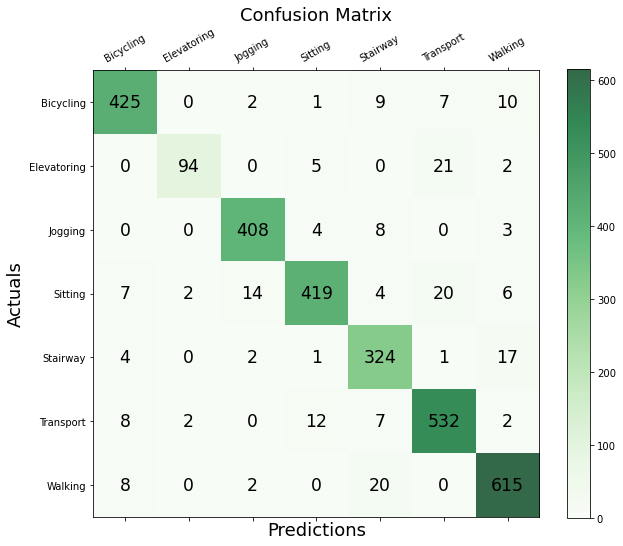

In [44]:
def plot_confusion(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.8)
    for row in range(conf_matrix.shape[0]):
        for col in range(conf_matrix.shape[1]):
            ax.text(x=col, y = row, s = conf_matrix[row, col], va='center', ha='center', size='xx-large')

    ax.tick_params(axis="x", rotation=30)
    classes = np.unique(y_test.unique())
    plt.xticks(np.arange(0,len(classes)), classes)
    plt.yticks(np.arange(0,len(classes)), classes)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.colorbar(im, shrink=0.825)
    plt.show()

plot_confusion(y_test, rs.predict(X_test))

Lift fahren scheint am wenigsten gut erkannt bzw. am meisten verwechselt zu werden. Dies war auch zu erwarten, da die Aktivität sehr ähnlich zu Stehen bzw. Sitzen oder Transport ist und bei dieser Aktivität am wenigsten Daten vorhanden sind. Anhand der Confusion-Matrix sieht man, dass sich unsere Annahmen bestätigen: Transport wird oft mit Sitzen/Stehen verwechselt, Laufen oft mit Treppensteigen. Ansonsten sind keine generellen Strukturen erkennbar.

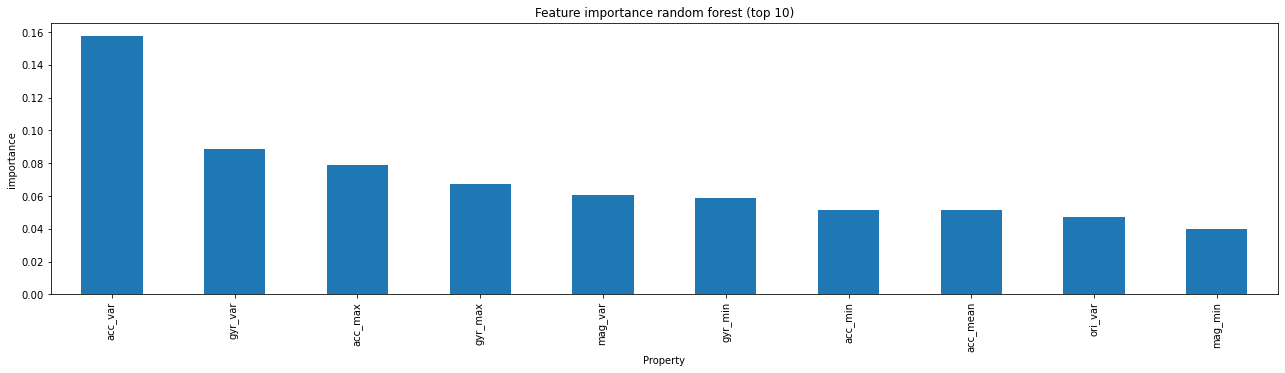

In [45]:
importances = pd.Series(rs.best_estimator_.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
importances[0:10].plot(kind='bar', figsize=(22, 5))
plt.title("Feature importance random forest (top 10)")
plt.xlabel("Property")
plt.ylabel("importance")
plt.show()

Hier wird deutlich, dass Varianzen den grössten Einfluss auf den Activity Typ haben. Der Accelometer und der Gyroskopsensor scheinen die Dominanten Sensoren zu sein und den grössten Einfluss zu haben.

## RFE

In [46]:
from sklearn.feature_selection import RFE

y = target["activity"]
X = df_agg.iloc[:, 2:]

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=8)
rfe.fit(X, y)
X = rfe.transform(X)
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X, y, stratify=y, test_size=0.2, random_state=27)

decision_tree_rfe = RandomForestClassifier(random_state = 27)
decision_tree_rfe.fit(X_train_rfe, y_train_rfe)
y_predicted_decision_tree_rfe = decision_tree_rfe.predict(X_test_rfe)
f1 = f1_score(y_test_rfe, y_predicted_decision_tree_rfe, average='macro')
print(f1)

0.8856567456246608


Da einige Sensoren vielleicht eher falsche Messungen machen oder anders das Modell negativ beeinflussen, haben wir verschiedene Tests mit Recursive Feature Elimination gemacht. Leider konnte auch dies unseren Score nicht verbessern.

## Random Forest nur mit den vier Hauptaktivitäten

Da wir in der Challenge vier Hauptaktiväten definiert haben (Laufen, Joggen, Sitzen, Fahrradfahren) möchten wir auch noch ein Modell nur auf diese trainieren. Dieses wird wahrscheinlich besser abschneiden, da die Ähnlichkeiten Sitzen - Fahrzeug und Laufen - Treppensteigen nicht mehr vorhanden sind.

Datensatz nach den vier Hauptaktivitäten filtern

In [47]:
reduced_activities = ["Walking", "Jogging", "Sitting", "Bicycling"]
reduced_df_clean = df_clean[df_clean['activity'].isin(reduced_activities)]

Gleiches Vorgehen der Datenvorbereitung wie bei dem vorherigen Modell

In [48]:
df_wind = reduced_df_clean.groupby(groups)
df_wind = df_wind.filter(lambda g: g.shape[0] > 50).groupby(groups)
target = df_wind[["name", "activity", "5s_index1"]].first().reset_index(drop=True)
df_agg = df_wind[df_clean.columns[3:8]].agg(["var", "mean", "median", "min", "max"]).reset_index()
np.array(df_agg.columns)
df_agg.columns = ['_'.join(column) for column in df_agg.columns]
df_agg = df_agg.drop(columns=["5s_index0_"])
X_train, X_test, y_train, y_test = train_test_split(df_agg.iloc[:, 2:], target["activity"], test_size=0.2, random_state=42)
target.activity.unique()

array(['Bicycling', 'Walking', 'Sitting', 'Jogging'], dtype=object)

In [49]:
if(run_mdls):
    log_range = np.logspace(0, 3, 10) / 1e+3 / 1
    model = RandomForestClassifier(n_jobs = -1, oob_score=True, warm_start=True)
    param_grid = {
        'n_estimators': [200, 250, 300],
        'max_depth': [30, 35, 40],
        'ccp_alpha': list(log_range / 100),
    }
    # scoring definition from https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='f1_weighted', n_iter=90, verbose=1, random_state=42)
    # fit on all data
    rs.fit(X_train, y_train)

else:
    rs = pickle.load(open('../models/rf_allprop.pkl', 'rb'))

print("")
print(f'Random Forest refit weighted f1:        {rs.score(X_test, y_test)}')
print(f'Random Forest best cv mean weighted f1: {rs.best_score_}')
print(f'Random Forest best parameters:          {rs.best_estimator_}')

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Random Forest refit weighted f1:        0.954139411618941
Random Forest best cv mean weighted f1: 0.9506859755169362
Random Forest best parameters:          RandomForestClassifier(ccp_alpha=2.1544346900318837e-05, max_depth=35,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       warm_start=True)


Wie erwartet ist der F1-Score hier nochmals höher als mit allen Aktivitäten.

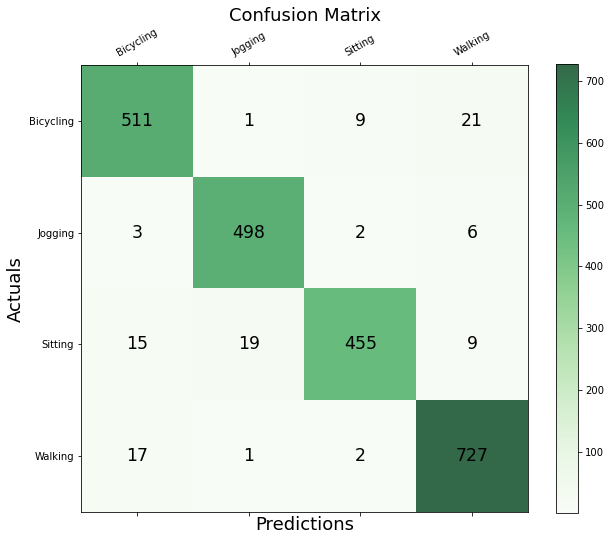

In [50]:
plot_confusion(y_test, rs.predict(X_test))

Es sind auch keine Strukturen in der Confusion-Matrix mehr zu sehen.

## Fazit

Die Modelle erreichen mit einem F1-Score von ca. 0.92 bei allen und ca. 0.95 bei den vier Hauptaktivtäten sehr hohe Werte. Noch höhere würden einen Overfit auf den Daten bedeuten, da einige Aktivitäten sehr ähnlich sind (wie zum Beispiel Zugfahren wenn der Zug steht und Sitzen oder Plateaus beim Treppensteigen) und wir während dem Erfassen der Daten wahrscheinlich auch ab und zu Fehler gemacht haben. So bleibt unser Modell noch gut anwendbar in der Praxis.